In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

### Testing Inpainting Baselines

---

In [42]:
from helpers.dataset import InpaintingDataset
from helpers.data_utils import post_process_image, numpy_to_pil, pil_black_to_white_bg

from diffusers import StableDiffusionInpaintPipeline, AutoPipelineForInpainting
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel

import torch

import numpy as np
from PIL import Image, ImageOps

from omegaconf import OmegaConf

### Data

In [124]:
prompt = "fill the missing parts of a fabric texture matching the existing colors and style, if not sure then fill with red"
negative_prompt = "no black parts"

In [95]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = 6611
sample = dataset[i]
diffuse_img, partial_img, mask = sample["full_diffuse_img"], sample["partial_diffuse_img"], sample["mask"]

In [96]:
target_img_pil = numpy_to_pil(post_process_image(diffuse_img))
partial_img_pil = numpy_to_pil(post_process_image(partial_img))
partial_img_pil_inv = pil_black_to_white_bg(partial_img_pil)

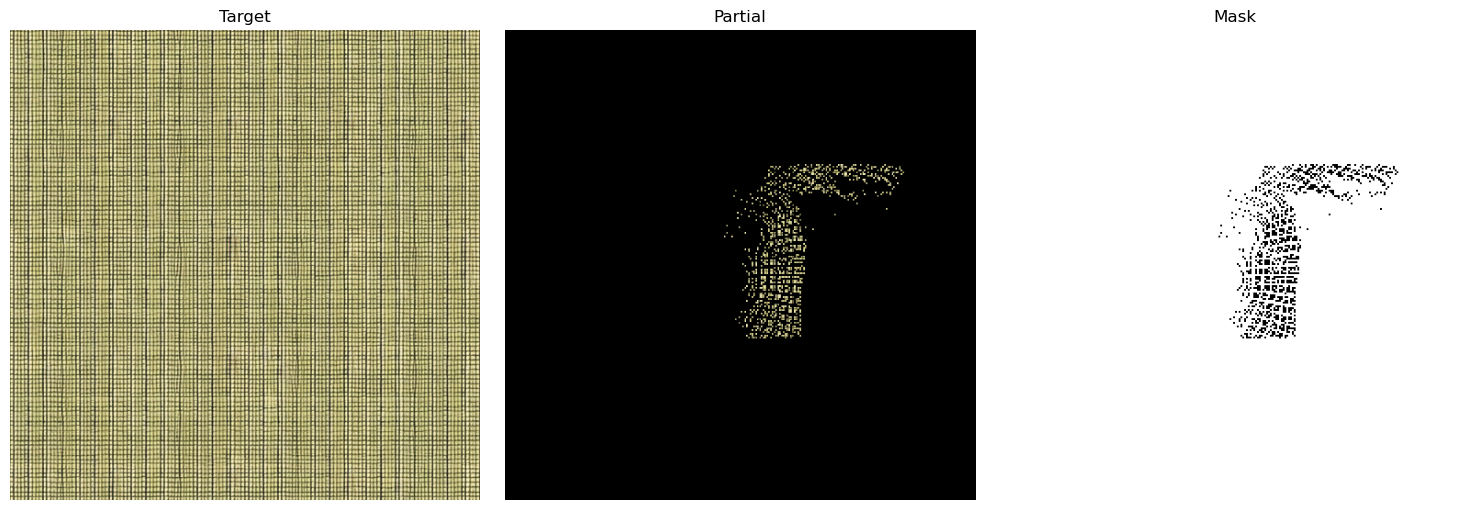

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(target_img_pil)
ax[0].set_title("Target")
ax[0].axis("off")

ax[1].imshow(partial_img_pil)
ax[1].set_title("Partial")
ax[1].axis("off")

ax[2].imshow(mask.transpose(1, 2, 0), cmap="gray")
# ax[2].set_title("Mask (1 = white -> fill , 0 = black -> keep)")
ax[2].set_title("Mask")
ax[2].axis("off")

plt.tight_layout()
plt.show()

#### Text based only

In [25]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
 "stable-diffusion-v1-5/stable-diffusion-v1-5",   # "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [40]:
result = pipe(prompt=prompt, image=partial_img_pil_inv, mask_image=mask, strength=0.25).images[0]

  0%|          | 0/12 [00:00<?, ?it/s]

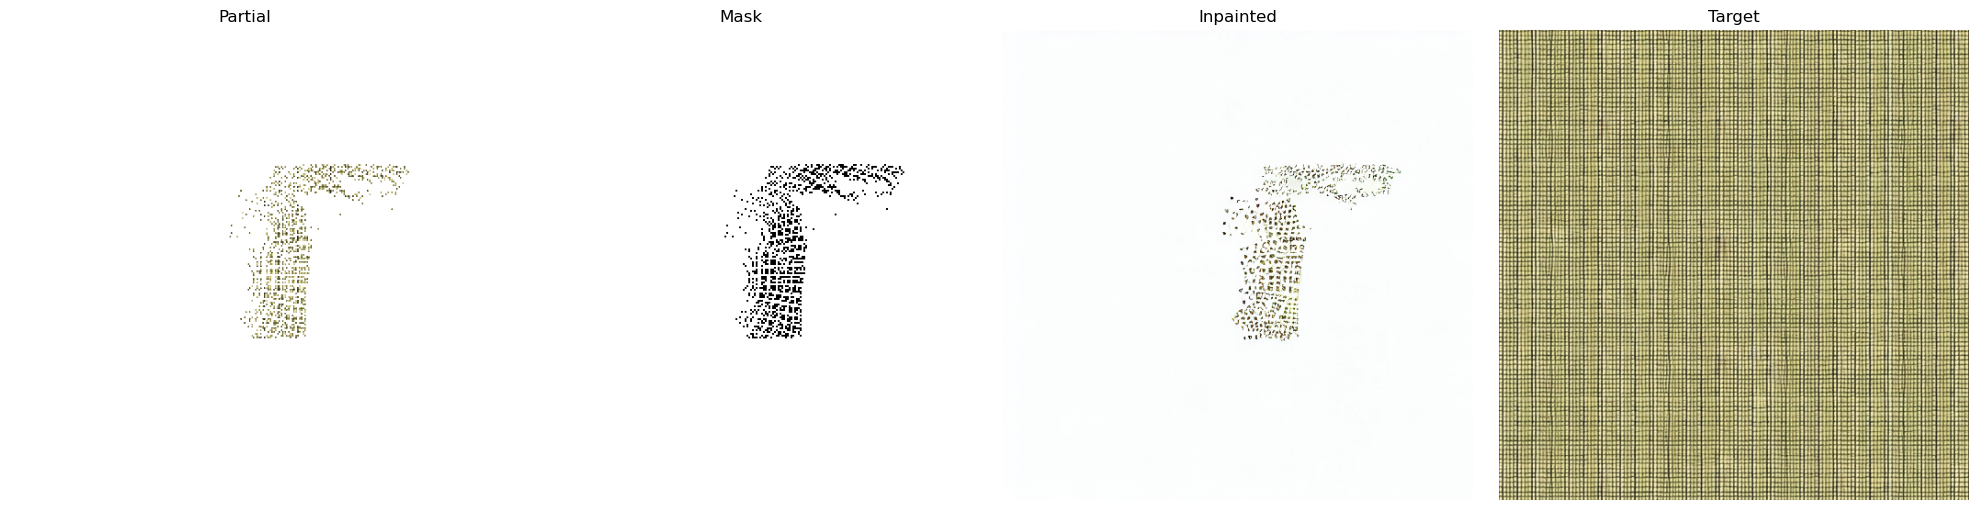

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(partial_img_pil_inv)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask.transpose(1, 2, 0), cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()

#### Text+Image inpainting

In [19]:
# Load the ControlNet model
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)

# Initialize the pipeline with ControlNet
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")

Keyword arguments {'allow_pickle': True} are not expected by StableDiffusionControlNetInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an e

In [22]:
result = pipe(prompt=prompt, image=partial_img_pil, mask_image=mask, control_image=partial_img_pil_inv, strength=0.95).images[0]

  0%|          | 0/47 [00:00<?, ?it/s]

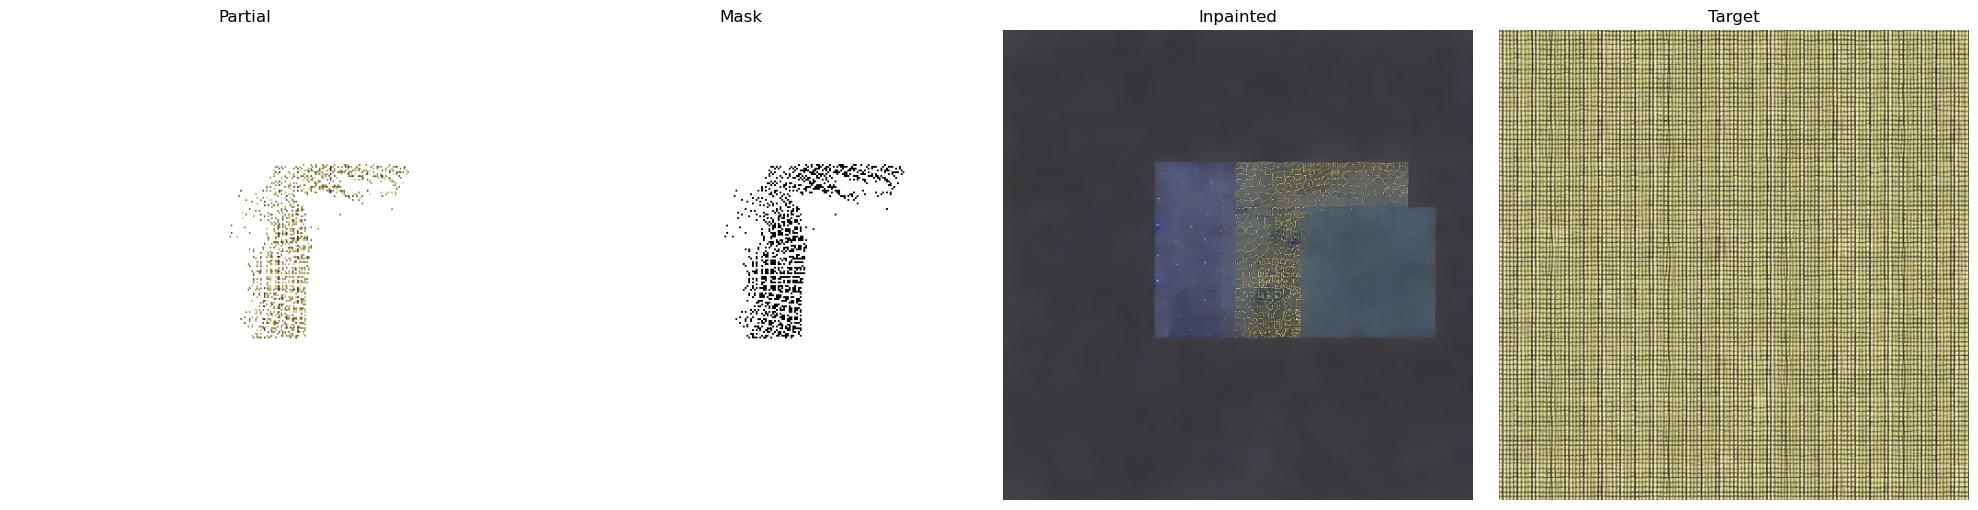

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(partial_img_pil_inv)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask.transpose(1, 2, 0), cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()

### Inpainting with task specific SD

In [43]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
 "sd-legacy/stable-diffusion-inpainting",   
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
).to("cuda")
pipe.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /scratch/izar/cizinsky/.cache/hf/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise 

In [127]:
result = pipe(prompt=prompt, image=partial_img_pil, mask_image=mask, strength=0.95, guidance_scale=10, num_inference_steps=50).images[0]

  0%|          | 0/47 [00:00<?, ?it/s]

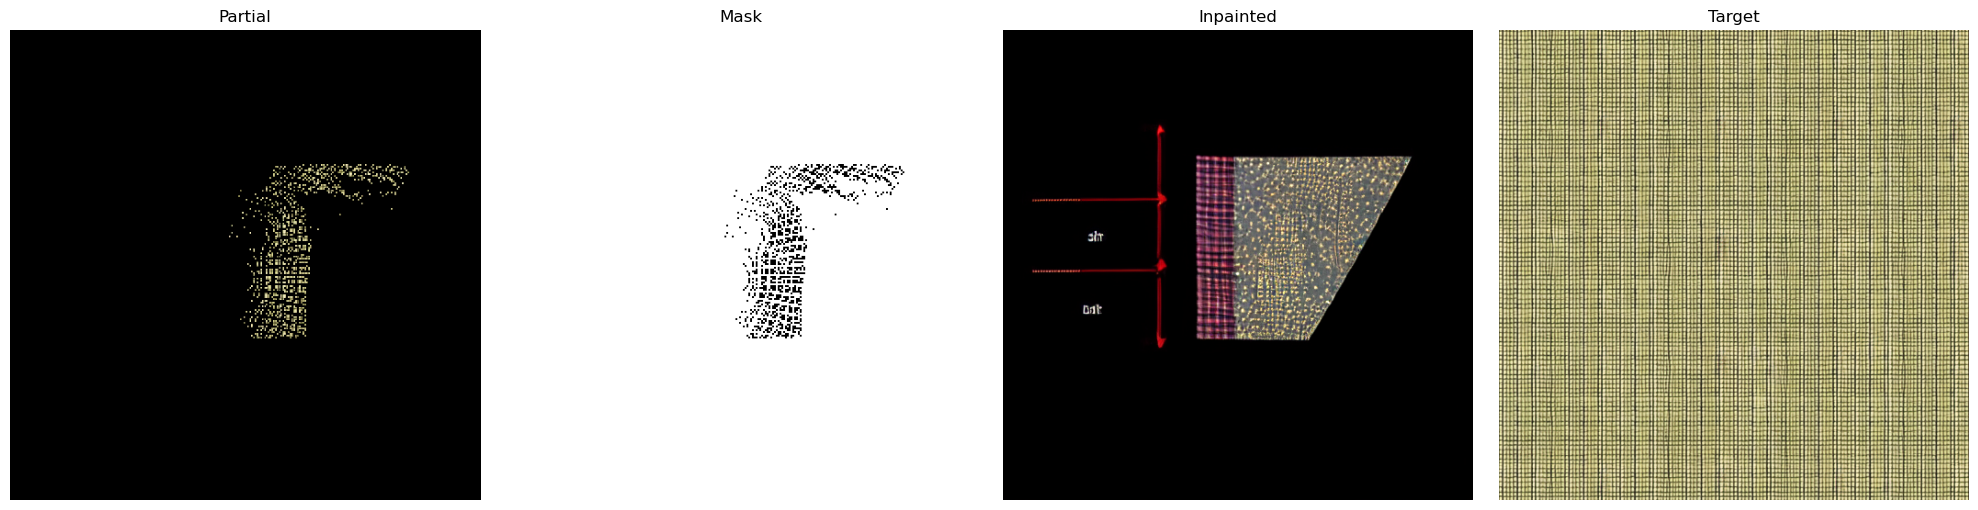

In [128]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(partial_img_pil)
ax[0].set_title("Partial")
ax[0].axis("off")

ax[1].imshow(mask.transpose(1, 2, 0), cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted")
ax[2].axis("off")

ax[3].imshow(target_img_pil)
ax[3].set_title("Target")
ax[3].axis("off")

plt.tight_layout()
plt.show()